<a href="https://colab.research.google.com/github/LolFolUp/AI/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Untitled6_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
data = pd.read_csv('Admission_Predict.csv') #1:00:38 показывается эта функция




Saving Admission_Predict.csv to Admission_Predict (1).csv


Чтобы постоянно не загружать файл

In [9]:
# Просмотр первых строк данных
print(data.head())

# Проверка типов данных и общая информация
print(data.shape)

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
(400, 9)


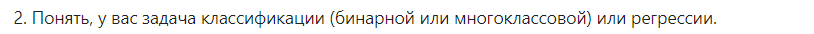

У нас регрессия(как в 5 говорил , что  у нас непрерывная случайная величина которую нужно предсказаать )

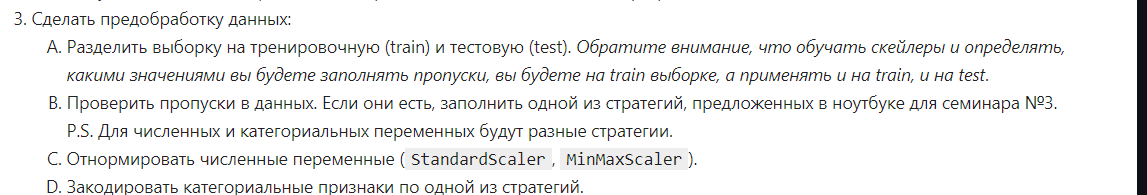

In [11]:
from sklearn.model_selection import train_test_split # в гите так
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

# Просмотр всех названий столбцов
print("Названия столбцов:", data.columns)

# Удалим лишние пробелы в названиях столбцов
data.columns = data.columns.str.strip() # хз почему но в X была ошибка мб пробелы или что-то еще





# ИКСЫ и ИГРЕКИ определяем
X = data.drop(columns=['Chance of Admit', 'Serial No.'])  # Удаляем Serial No., так как это просто индекс
y = data['Chance of Admit']
print("ПРОШЛО пока что")
# КАК В ЛЕКЦИИ копируем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # все как в лекции ТОЛЬКО random поставил другой было там 17

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# ПРоверяем пропуски(ХОТЯ еще на первой сдаче мы выяснили что их нет)
print("Пропуски в тренировочной выборке:")
print(X_train.isnull().sum())

# Если есть пропуски, заполним их медианой(либо чем-то еще если смотреть на лекцию) для числовых переменных(пропусков нет так как мы это выяснили еще при первой сдаче , но все же)
for column in X_train.columns:
    if X_train[column].isnull().sum() > 0:
        median = X_train[column].median()
        X_train[column].fillna(median, inplace=True)
        X_test[column].fillna(median, inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Обучаем на train и применяем
X_test_scaled = scaler.transform(X_test)        # Применяем на test

# Преобразуем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("СТАНДАРТ ПРОШЕЛ")

# 5. Нормализация численных переменных с помощью MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)  # Обучаем на train и применяем
X_test_minmax = minmax_scaler.transform(X_test)        # Применяем на test

# Преобразуем обратно в DataFrame для удобства
X_train_minmax = pd.DataFrame(X_train_minmax, columns=X_train.columns)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=X_test.columns)

print("MinMaxScaler ПРОШЕЛ.")

cat_columns = X.select_dtypes(include=['object']).columns
if len(cat_columns) == 0:
    print("нет категориальных признаков.")
else:
    print(f"Найдены категориальные признаки: {list(cat_columns)}")


Названия столбцов: Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')
ПРОШЛО пока что
Размер тренировочной выборки: (320, 7)
Размер тестовой выборки: (80, 7)
Пропуски в тренировочной выборке:
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64
СТАНДАРТ ПРОШЕЛ
MinMaxScaler ПРОШЕЛ.
нет категориальных признаков.


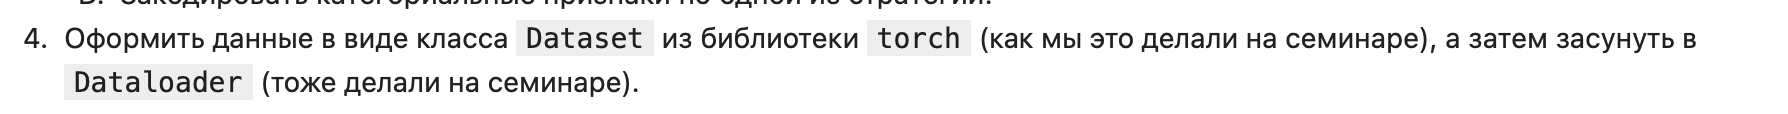

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# Класс Dataset
class AdmissionDataset(Dataset): # 44:47 наследуем от даты сета и реализуем 3 метода
    def __init__(self, X, y):# конструктор (прописываем все сущности которые могут на понадобиться )
        self.X = torch.tensor(X.values, dtype=torch.float32)# tensonr крч переобразует массив numpy  для массива торча (чтобы торч смог работать с массивом)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self): # размер даты сета
        return len(self.X)

    def __getitem__(self, idx):  # тендер метод который обеспечивают логику взаимодействия когда мы образщаемся через кв скобки условно a[3]. смотрим на специфику
    #  задачимне нужны
        return self.X[idx], self.y[idx]

# создаем дата сет просто трейн-трейн, тест-тест
train_dataset = AdmissionDataset(X_train_scaled, y_train)
test_dataset = AdmissionDataset(X_test_scaled, y_test)

# Параметры DataLoader(крч это если слишкрм нагружено мы делим на батчеры, всегда так делаем потому что слишком много занимает и гг компьютеру)
batch_size = 32

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Проверка
for X_batch, y_batch in train_loader:
    print("Пример X_batch:", X_batch)
    print("Пример y_batch:", y_batch)
    break


Пример X_batch: tensor([[ 1.1668,  1.0892,  0.8160,  1.1076, -0.5019,  0.9908,  0.9276],
        [ 0.6345,  0.7569,  0.8160,  0.6174, -1.0597, -0.8302,  0.9276],
        [-0.0751, -1.5689, -1.8038, -1.8338, -1.6174, -1.9704, -1.0780],
        [-1.8492, -1.0705, -1.8038, -0.8533, -0.5019, -1.5449, -1.0780],
        [ 0.7232,  0.7569, -0.9306, -0.3631,  0.0558,  0.6334,  0.9276],
        [-1.4944, -1.2366, -0.0573, -1.3436, -0.5019,  0.1228,  0.9276],
        [ 0.5458,  0.7569,  1.6892,  0.6174,  1.1712,  0.3271, -1.0780],
        [ 0.8119,  0.4247, -0.0573,  0.1272,  0.0558,  0.2930,  0.9276],
        [-0.3412, -0.9044, -0.0573, -1.3436, -0.5019, -0.5409, -1.0780],
        [-0.1638, -1.2366, -1.8038, -1.3436, -1.0597, -1.0854, -1.0780],
        [-0.9622, -0.4060, -0.9306, -0.3631, -1.0597, -0.5579, -1.0780],
        [-0.5187, -0.4060, -0.9306, -0.3631, -1.6174, -0.7961,  0.9276],
        [-1.4057, -0.5721, -0.9306,  0.1272,  0.0558, -1.1875,  0.9276],
        [ 0.1910,  0.4247, -0.0573,

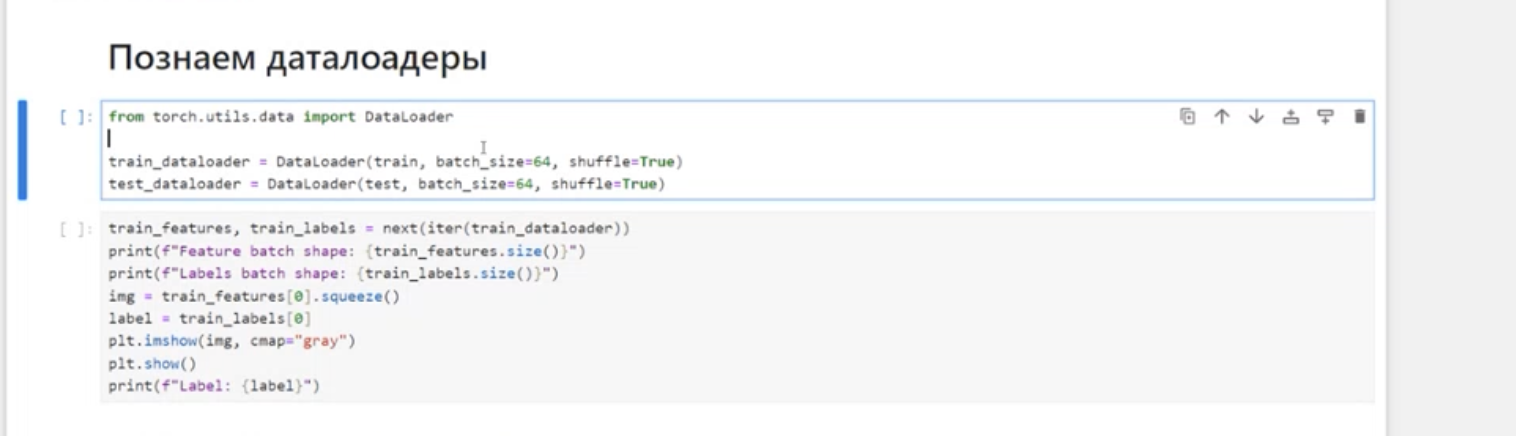

Подгружает дата сеты, перемешивает данные и разбивает на батчи(кол-во наблюдений в одном батче когда у нас оперативы не хватает на компе все загрузить грубо говоря кусок данных)

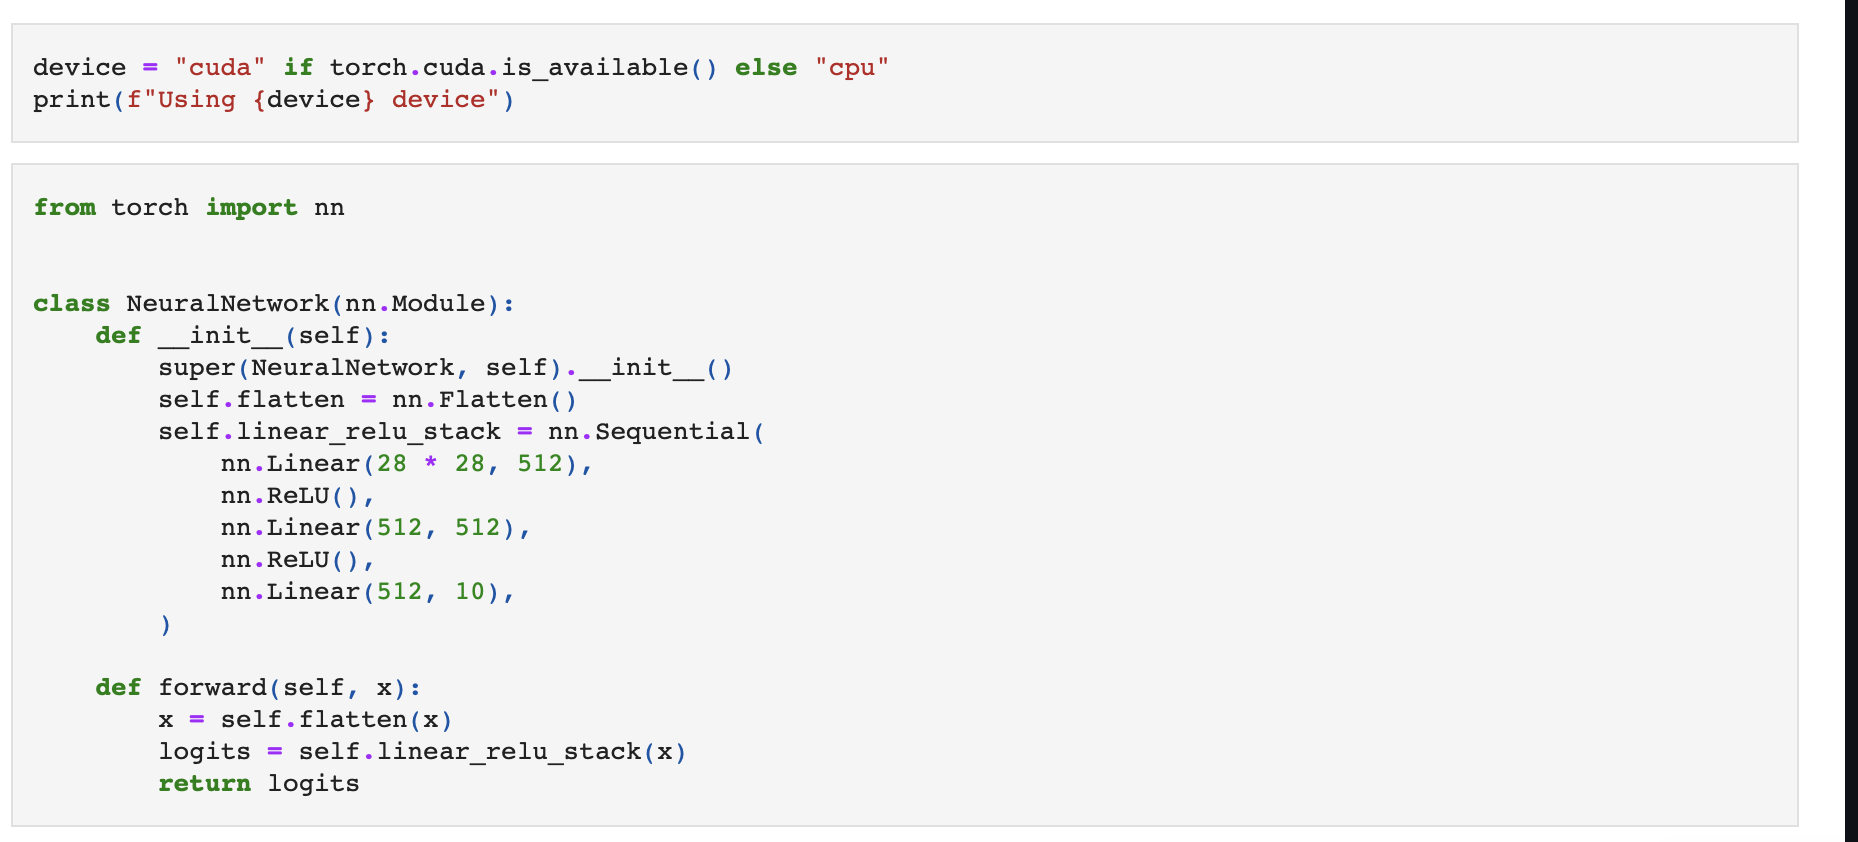

Скрин из 53:14. ПОлезно нерйронку в класс обернуть. nn флеттен из матрицы вектор делает. можем перечеслять нужные нам слои. вход 28 на 28 выход 512, далее слой вход 512  и выход 512. ReLU -- активация. НА ВЫХОДЕ 10 классов. forward -- метод который работает с инпутом который будет туда затекать

Обучить на тренировочном множестве:
Очень простую однослойную нейросеть с оптимизатором SGD (link).

1 слой

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Один линейный слой: вход -> выход

    def forward(self, x):
        return self.linear(x)  # Прямое распространение


# Размер входного слоя равен количеству признаков
input_size = X_train_scaled.shape[1]

# Создаем модель
model = SimpleNN(input_size)

# Печатаем модель для проверки
print(model)


# Функция потерь
criterion = nn.MSELoss()

# Оптимизатор ТАКОЙ ЖЕ КАК В ЛЕКЦИИ ПОСТАВИЛ(и по заданию)
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Параметры обучения
num_epochs = 100  # Количество эпох

# Обучение
for epoch in range(num_epochs):
    model.train()  # Перевод модели в режим обучения
    epoch_loss = 0  # Суммарная ошибка за эпоху

    for X_batch, y_batch in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямое распространение
        predictions = model(X_batch)

        # Вычисление ошибки
        loss = criterion(predictions, y_batch)

        # Обратное распространение
        loss.backward()

        # Обновление параметров
        optimizer.step()

        # Суммируем ошибку
        epoch_loss += loss.item()

    # Печатаем ошибку каждые 10 эпох(крч также было в лекции но там каждые 5 эпох)
    if (epoch + 1) % 10 == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}], Ошибка: {epoch_loss/len(train_loader):.4f}")


SimpleNN(
  (linear): Linear(in_features=7, out_features=1, bias=True)
)
Эпоха [10/100], Ошибка: 0.0364
Эпоха [20/100], Ошибка: 0.0094
Эпоха [30/100], Ошибка: 0.0058
Эпоха [40/100], Ошибка: 0.0046
Эпоха [50/100], Ошибка: 0.0042
Эпоха [60/100], Ошибка: 0.0040
Эпоха [70/100], Ошибка: 0.0039
Эпоха [80/100], Ошибка: 0.0039
Эпоха [90/100], Ошибка: 0.0039
Эпоха [100/100], Ошибка: 0.0039


1 открытый

In [14]:
class SimpleNNWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNNWithHiddenLayer, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Скрытый слой
        self.output = nn.Linear(hidden_size, 1)          # Выходной слой

    def forward(self, x):
        x = torch.relu(self.hidden(x))  # Активация ReLU для скрытого слоя
        x = self.output(x)              # Линейный выход
        return x
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_size = 64  # Размер скрытого слоя

# Создаем модель
model1 = SimpleNNWithHiddenLayer(input_size, hidden_size)
print(model1)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model1.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model1(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}], Ошибка: {epoch_loss/len(train_loader):.4f}")


SimpleNNWithHiddenLayer(
  (hidden): Linear(in_features=7, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)
Эпоха [10/100], Ошибка: 0.0050
Эпоха [20/100], Ошибка: 0.0039
Эпоха [30/100], Ошибка: 0.0035
Эпоха [40/100], Ошибка: 0.0030
Эпоха [50/100], Ошибка: 0.0028
Эпоха [60/100], Ошибка: 0.0029
Эпоха [70/100], Ошибка: 0.0038
Эпоха [80/100], Ошибка: 0.0025
Эпоха [90/100], Ошибка: 0.0025
Эпоха [100/100], Ошибка: 0.0028


3 слоя

In [15]:
class ComplexNNWithHiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(ComplexNNWithHiddenLayers, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])  # Первый скрытый слой
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Второй скрытый слой
        self.hidden3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])  # Третий скрытый слой
        self.output = nn.Linear(hidden_sizes[2], 1)                 # Выходной слой

    def forward(self, x):
        x = torch.relu(self.hidden1(x))  # Активация ReLU для первого слоя
        x = torch.relu(self.hidden2(x))  # Активация ReLU для второго слоя
        x = torch.relu(self.hidden3(x))  # Активация ReLU для третьего слоя
        x = self.output(x)               # Линейный выход
        return x
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_sizes = [128, 64, 32]  # Размеры скрытых слоев

# Создаем модель
model2 = ComplexNNWithHiddenLayers(input_size, hidden_sizes)
print(model2)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model2(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}], Ошибка: {epoch_loss/len(train_loader):.4f}")


ComplexNNWithHiddenLayers(
  (hidden1): Linear(in_features=7, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)
Эпоха [10/100], Ошибка: 0.0035
Эпоха [20/100], Ошибка: 0.0033
Эпоха [30/100], Ошибка: 0.0028
Эпоха [40/100], Ошибка: 0.0021
Эпоха [50/100], Ошибка: 0.0016
Эпоха [60/100], Ошибка: 0.0017
Эпоха [70/100], Ошибка: 0.0021
Эпоха [80/100], Ошибка: 0.0011
Эпоха [90/100], Ошибка: 0.0010
Эпоха [100/100], Ошибка: 0.0014


Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки matplotlib (выйдет так называемая learning curve, кривая обучения модели).

Эпоха [10/100], Train Loss: 0.0001, Test Loss: 0.0063
Эпоха [20/100], Train Loss: 0.0002, Test Loss: 0.0069
Эпоха [30/100], Train Loss: 0.0002, Test Loss: 0.0064
Эпоха [40/100], Train Loss: 0.0001, Test Loss: 0.0060
Эпоха [50/100], Train Loss: 0.0001, Test Loss: 0.0067
Эпоха [60/100], Train Loss: 0.0001, Test Loss: 0.0064
Эпоха [70/100], Train Loss: 0.0000, Test Loss: 0.0064
Эпоха [80/100], Train Loss: 0.0002, Test Loss: 0.0069
Эпоха [90/100], Train Loss: 0.0016, Test Loss: 0.0064
Эпоха [100/100], Train Loss: 0.0011, Test Loss: 0.0060


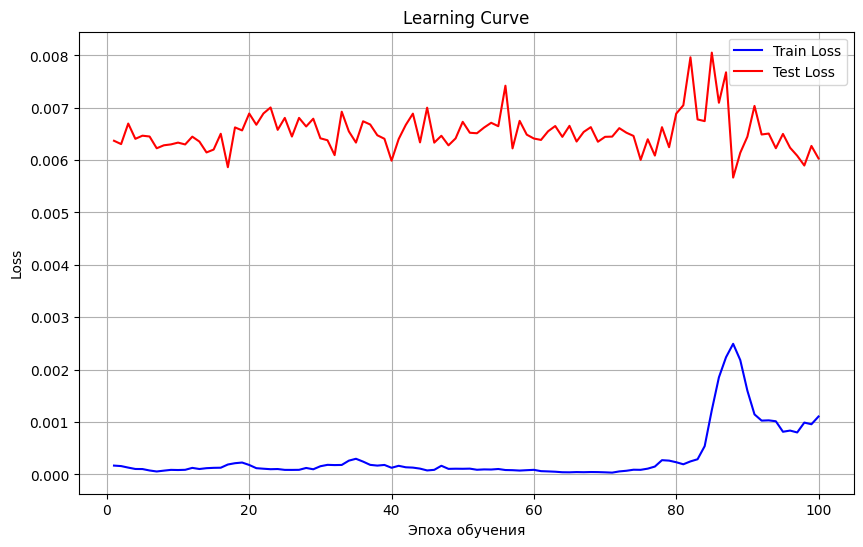

In [21]:
import matplotlib.pyplot as plt

# Параметры обучения
num_epochs = 100
train_losses = []  # Хранение loss на train
test_losses = []   # Хранение loss на test

# Обучение
for epoch in range(num_epochs):
    model2.train()  # Перевод модели в режим обучения
    epoch_train_loss = 0

    # Проходим по всему train_loader
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()               # Обнуляем градиенты
        predictions = model2(X_batch)       # Прямое распространение
        loss = criterion(predictions, y_batch)  # Вычисляем loss
        loss.backward()                     # Обратное распространение
        optimizer.step()                    # Шаг оптимизации
        epoch_train_loss += loss.item()     # Суммируем loss

    # Средний loss на train за эпоху
    train_losses.append(epoch_train_loss / len(train_loader))

    # Оценка на test
    model2.eval()  # Перевод модели в режим оценки
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model2(X_batch)
            loss = criterion(predictions, y_batch)
            epoch_test_loss += loss.item()

    # Средний loss на test за эпоху
    test_losses.append(epoch_test_loss / len(test_loader))

    # Печатаем loss каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Визуализация learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


Посчитайте метрики на train и test множествах:
Для задачи классификации -- Accuracy
Для задачи регрессии -- MAE

In [17]:
from sklearn.metrics import mean_absolute_error

# Перевод модели в режим оценки
model2.eval()

# Предсказания и расчет MAE на train
train_predictions = []
train_actuals = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        preds = model2(X_batch)  # Предсказания
        train_predictions.append(preds.numpy())
        train_actuals.append(y_batch.numpy())

# Преобразуем списки в массивы
train_predictions = np.vstack(train_predictions)
train_actuals = np.vstack(train_actuals)

# Расчет MAE на train
mae_train = mean_absolute_error(train_actuals, train_predictions)
print(f"MAE на тренировочной выборке: {mae_train:.4f}")

# Предсказания и расчет MAE на test
test_predictions = []
test_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model2(X_batch)  # Предсказания
        test_predictions.append(preds.numpy())
        test_actuals.append(y_batch.numpy())

# Преобразуем списки в массивы
test_predictions = np.vstack(test_predictions)
test_actuals = np.vstack(test_actuals)

# Расчет MAE на test
mae_test = mean_absolute_error(test_actuals, test_predictions)
print(f"MAE на тестовой выборке: {mae_test:.4f}")


MAE на тренировочной выборке: 0.0177
MAE на тестовой выборке: 0.0548


Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
Какая модель справилась лучше с поставленной задачей?
Имеет ли место переобучение?
Имеет ли место недообучение?
Как можно улучшить метрики моделей?

чет огромное переобучение